# Smooth case

Smooth case example:
$$ \int_0^1 |u|^2\,\mathrm{d}t \to \min, $$
$$ \dot{q} = v, $$
$$ \dot{v} = -\lambda v^2 + u, $$
with $q$ and $v$ fixed at $t=0$ and $t=1$. Denoting $x=(q, v)$, the Lagrange cost functional is defined by
$$ f^0(t, x, u, \lambda) = u^2, $$
while the dynamics is
$$ f(t, x, u, \lambda) = (v, -\lambda v^2+u). $$

Denoting $p=(p_q,p_v)$, in the normal case ($p^0=-1/2$), the dynamic feedback is $u=p_v$, so the maximized Hamiltonian of the problem is
$$ H(t, x, p, \lambda) = p_q v + p_v(-\lambda v^2 + u) - u^2/2. $$

## Basic tests

/Users/caillau/anaconda3/envs/solvers-ct/lib/python3.7/site-packages/jax/lib/xla_bridge.py:122: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


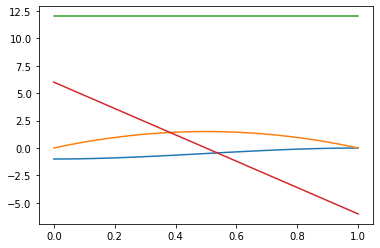

In [1]:
from ocp import *
import matplotlib.pyplot as plt
import time
from scipy.optimize import root

def h1fun(t, x, p, lbda):
    """h1fun(t, x, p, lbda) = pv^2/2 + pq v - lbda pv v^2

    Normal Hamiltonian associated with \int_0^1 |u|^2 dt -> min and
    dq/dt = v, dv/dt = -lambda v^2 + u."""
    q, v = x
    pq, pv = p
    h1 = pv**2/2. + pq*v - lbda*pv*v**2
    return h1

def grad_h1fun(t, x, p, lbda):
    """ v = grad_h1fun(t, x, p, lbda)

    Gradient of h1fun"""
    q, v = x
    pq, pv = p
    grad = np.array([ 0., 0., pq-2.*lbda*pv*v, v, pv-lbda*v**2, -pv*v**2 ])
    return grad

def hess_h1fun(t, x, p, lbda):
    """h = hess_h1fun(t, x, p, lbda)

    Hessian of h1fun"""
    q, v = x
    pq, pv = p
    hess = np.array([ [ 0., 0.,          0., 0.,        0.,      0. ],
                      [ 0., 0.,          0., 0.,        0.,      0. ],
                      [ 0., 0., -2.*lbda*pv, 1., -2*lbda*v, -2*pv*v ],
                      [ 0., 0.,          1., 0.,        0.,      0. ],
                      [ 0., 0.,  -2.*lbda*v, 0.,        1.,   -v**2 ],
                      [ 0., 0.,     -2*pv*v, 0.,     -v**2,      0. ] ])
    return hess

t0 = 0.
x0 = np.array([ -1., 0. ])
p0 = np.array([ 12.00120012, 6.00060006 ] )
lbda = 0.
h1 = Hamiltonian(h1fun, grad_h1fun, hess_h1fun) # no AD
f1 = Flow(h1)
tf = 1.
N = 100
tspan = np.linspace(t0, tf, N)
xf, pf = f1.val(t0, x0, p0, tf, lbda)
tout, xout, pout = f1.val(t0, x0, p0, tf, lbda, tspan=tspan)

plt.ion() # interactive mode on
plt.plot(tout, xout[:, 0])
plt.plot(tout, xout[:, 1])
plt.plot(tout, pout[:, 0])
plt.plot(tout, pout[:, 1])
plt.show()

## Shooting
- `h1`: without AD (= Automatic Differentiation)
- `h2`: with AD
- `h3`: with AD and Hamiltonian built from `OCP`

Initialization taken from `BOCOP`. All solves with `scipy.optimize.root` + DF / `nle.solve` + DF / `nle.solve` + VAR

In [2]:
# h1
xf_fixed = np.array([ 0., 0. ]) # target is xf = (0, 0)
p0 = np.array([ 12.00120012, 6.00060006 ] ) - np.array([ 6., 7. ]) # from BOCOP (+/- some perturbation)

def shoot1(p0):
    """s = shoot1(p0)

    Shooting function associated with h1"""
    xf, pf = f1.val(t0, x0, p0, tf, lbda)
    s = xf - xf_fixed
    return s

def dshoot1(p0):
    """ds = dshoot1(p0)
    
    Jacobian of shooting function associated with h1"""
    dxf, dpf = f1.dp0(t0, x0, p0, tf, lbda)
    return dxf

et = time.time(); sol1 = root(shoot1, p0, method='hybr', jac=None); p0_sol1 = sol1.x; et = time.time() - et
print('root + DF\t: time = ', et, 'p0_sol1 =', p0_sol1, 'shoot1 =', shoot1(p0_sol1))

nleopt = nle.Options(Display='on', TolX=1e-8)
et = time.time(); sol1 = nle.solve(shoot1, p0, options=nleopt); p0_sol1 = sol1.x; et = time.time() - et
print('nle  + DF\t: time = ', et, 'p0_sol1 =', p0_sol1, 'shoot1 =', shoot1(p0_sol1))

nleopt = nle.Options(SolverMethod='hybrj', Display='on', TolX=1e-8)
et = time.time(); sol1 = nle.solve(shoot1, p0, jac=dshoot1, options=nleopt); p0_sol1 = sol1.x; et = time.time() - et
print('nle  + VAR\t: time = ', et, 'p0_sol1 =', p0_sol1, 'shoot1 =', shoot1(p0_sol1))

root + DF	: time =  0.8009951114654541 p0_sol1 = [12.  6.] shoot1 = [-1.11022302e-15  2.22044605e-16]
nle  + DF	: time =  0.7183630466461182 p0_sol1 = [12.  6.] shoot1 = [-3.33066907e-16 -3.10862447e-15]
nle  + VAR	: time =  5.5028979778289795 p0_sol1 = [12.  6.] shoot1 = [0. 0.]


In [3]:
# h2
h2 = Hamiltonian(h1fun) # AD for gradient and Hessian of h1fun
f2 = Flow(h2)

def shoot2(p0):
    """s = shoot2(p0)

    Shooting function associated with h2"""
    xf, pf = f2.val(t0, x0, p0, tf, lbda)
    s = xf - xf_fixed
    return s

def dshoot2(p0):
    """ds = dshoot2(p0)
    
    Jacobian of shooting function associated with h2"""
    dxf, dpf = f2.dp0(t0, x0, p0, tf, lbda)
    return dxf

et = time.time(); sol2 = root(shoot2, p0, method='hybr', jac=None); p0_sol2 = sol2.x; et = time.time() - et
print('root + DF\t: time = ', et, 'p0_sol2 =', p0_sol2, 'shoot2 =', shoot2(p0_sol2))

nleopt = nle.Options(Display='on', TolX=1e-8)
et = time.time(); sol2 = nle.solve(shoot2, p0, options=nleopt); p0_sol2 = sol2.x; et = time.time() - et
print('nle  + DF\t: time = ', et, 'p0_sol2 =', p0_sol2, 'shoot2 =', shoot2(p0_sol2))

nleopt = nle.Options(SolverMethod='hybrj', Display='on', TolX=1e-8)
et = time.time(); sol2 = nle.solve(shoot2, p0, jac=dshoot2, options=nleopt); p0_sol2 = sol2.x; et = time.time() - et
print('nle  + VAR\t: time = ', et, 'p0_sol2 =', p0_sol2, 'shoot2 =', shoot2(p0_sol2))

root + DF	: time =  3.485203981399536 p0_sol2 = [12.  6.] shoot2 = [-1.11022302e-15  2.22044605e-16]
nle  + DF	: time =  2.8687610626220703 p0_sol2 = [12.  6.] shoot2 = [-3.33066907e-16 -3.10862447e-15]
nle  + VAR	: time =  19.616640090942383 p0_sol2 = [12.  6.] shoot2 = [0. 0.]


In [4]:
# h3
def cost1fun(t, x, u, lbda):
    c = u**2
    return c

def dyn1fun(t, x, u, lbda):
    q, v = x
    dx = np.array([ v, u-lbda*v**2 ])
    return dx

o = OCP(cost1fun, dyn1fun)

def control1fun(t, x, p, lbda):
    pq, pv = p
    u = pv
    return u

h3 = Hamiltonian.fromOCP(o, control1fun, -0.5) # AD for gradient and Hessian of Hamiltonian from OCP
f3 = Flow(h3)

def shoot3(p0):
    """s = shoot3(p0)

    Shooting function associated with h3"""
    xf, pf = f3.val(t0, x0, p0, tf, lbda)
    s = xf - xf_fixed
    return s

def dshoot3(p0):
    """ds = dshoot3(p0)
    
    Jacobian of shooting function associated with h3"""
    dxf, dpf = f3.dp0(t0, x0, p0, tf, lbda)
    return dxf

et = time.time(); sol3 = root(shoot3, p0, method='hybr', jac=None); p0_sol3 = sol3.x; et = time.time() - et
print('root + DF\t: time = ', et, 'p0_sol3 =', p0_sol3, 'shoot3 =', shoot3(p0_sol3))

nleopt = nle.Options(Display='on', TolX=1e-8)
et = time.time(); sol3 = nle.solve(shoot3, p0, options=nleopt); p0_sol3 = sol3.x; et = time.time() - et
print('nle  + DF\t: time = ', et, 'p0_sol3 =', p0_sol3, 'shoot3 =', shoot3(p0_sol3))

nleopt = nle.Options(SolverMethod='hybrj', Display='on', TolX=1e-8)
et = time.time(); sol3 = nle.solve(shoot3, p0, jac=dshoot3, options=nleopt); p0_sol3 = sol3.x; et = time.time() - et
print('nle  + VAR\t: time = ', et, 'p0_sol3 =', p0_sol3, 'shoot3 =', shoot3(p0_sol3))

root + DF	: time =  3.5551340579986572 p0_sol3 = [12.  6.] shoot3 = [-1.11022302e-15  2.22044605e-16]
nle  + DF	: time =  3.1776866912841797 p0_sol3 = [12.  6.] shoot3 = [-3.33066907e-16 -3.10862447e-15]
nle  + VAR	: time =  20.628870010375977 p0_sol3 = [12.  6.] shoot3 = [0. 0.]
